<a href="https://colab.research.google.com/github/nparslow/disfluency_gen/blob/develop/docs/tutorials/nmt_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:

# refactored and adapted from:
#https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb

import os
import sys
repoRoot = os.path.abspath(os.path.join(os.getcwd(), '..'))

# for local running without installing the package:
sys.path.append(os.path.join(repoRoot, "src"))

import tensorflow as tf
from disfluency_generator.data_preparation import load_data, create_dataset, print_examples, \
     tf_lower_and_split_punct, create_text_processor
from disfluency_generator.encoder import Encoder
from disfluency_generator.decoder import Decoder
from disfluency_generator.trainTranslator import TrainTranslator, BatchLogs
from disfluency_generator.maskedLoss import MaskedLoss
from disfluency_generator.translator import Translator
from disfluency_generator.trainTranslator import TrainTranslator

import pathlib

from disfluency_generator.letsread_prepare_translations import LetsReadDataPrep
from disfluency_generator.portuguese_phoneme_to_grapheme import PhonemeToGrapheme

print("Checking the GPU is accessible:")
print(tf.config.list_physical_devices('GPU'))


Checking the GPU is accessible:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
# load data
data_path = pathlib.Path(repoRoot, "data")
verbose = 1
#------------------
letsread_corpus_path = os.path.join(data_path, "LetsReadDB")

p2g = PhonemeToGrapheme(os.path.join(repoRoot, "resources", "sampa.tsv"))
data_prep = LetsReadDataPrep(letsread_corpus_path, p2g)
inputs, targets = data_prep.prep_letsread()


if verbose > 0:
    print(f"Last example of data:\n{inputs[-1]}\n{targets[-1]}")

# we'll leave off the first 20 as a test set (todo improve)
dataset = create_dataset(inputs[20:], targets[20:], BATCH_SIZE=64//2)

if verbose > 0:
    print("")
    print("Printing Examples (before normalisation):")
    print_examples(dataset, 5)


Cannot parse t6j~ at ~
Cannot parse lun6w at w
Cannot parse fi...ka...@ju at ju
Cannot parse kumunica at ca
Cannot parse gOc6~w~ at c6~w~
Cannot parse tevulz6w~ at w~
Cannot parse sÂj~ at Âj~
Likely typo: [l"a:du
Likely typo: [i~v@rn"ar
Cannot parse k6ir6w~ at w~
Last example of data:
flole mocla ambife dantrar mever
flole mocla ambife dantrar e mever

Printing Examples (before normalisation):
Quis seguir viagem, mas estava tão fraco, magro e pálido, que eles não o deixaram partir.
quis seguir viagem mas estava tão fraco magro e a pal e pálido que que eles não o deixaram partir
--------------------
Diz a cabra que estava na vinha, que está pronta para ser a madrinha.
diz a cabra que estava ai que estava na vinha que estaa pronta para ser a madrinha
--------------------
Na noite de Natal, em frente da enorme lareira, havia uma mesa muito comprida.
na noite *DEL(de) natal em frente da enorme lareira havia uma mesa muito comprida
--------------------
Como teria acontecido?
como teria acon

In [17]:

# todo - check with corpus:
max_vocab_size = 2917

input_text_processor = create_text_processor(inputs, max_vocab_size)

if verbose > 0:
    # todo better checking:
    print("First 10 words of input vocab:")
    print(input_text_processor.get_vocabulary()[:10])

# note - we don't have to have the same output vocab size:
output_text_processor = create_text_processor(targets, max_vocab_size)

if verbose > 0:
    print("First 10 words of target vocab:")
    print(output_text_processor.get_vocabulary()[:10])

if verbose > 0:
    for example_input_batch, example_target_batch in dataset.take(1):
        print("Example input token sequences (indices):")
        example_tokens = input_text_processor(example_input_batch)
        print(example_tokens[:3, :10])


First 10 words of input vocab:
['', '[UNK]', '[START]', '[END]', 'a', 'e', 'o', 'de', 'que', 'um']
First 10 words of target vocab:
['', '[UNK]', '[START]', '[END]', 'a', 'e', 'o', 'de', 'que', 'um']
Example input token sequences (indices):
tf.Tensor(
[[   2  645 1731    7    9  239    3    0    0    0]
 [   2   30  169  351 2542    3    0    0    0    0]
 [   2    6  776   15  613    5   41   22  707    5]], shape=(3, 10), dtype=int64)


Before getting into it define a few constants for the model:

In [28]:
# The original model was built on more data, we shrink things down for the letsread corpus 
embedding_dim = 256//2
units = 1024//2

### Train the model


In [29]:

batch_loss = BatchLogs('batch_loss')

In [30]:

train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.002),  # default learning_rate = 0.001
    loss=MaskedLoss(),
)


In [31]:
# learning rate high at first:
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [32]:
train_translator.fit(dataset, epochs=60,
                     callbacks=[batch_loss, learning_rate_scheduler])

Epoch 1/60
71/71 [==============================] - 27s 335ms/step - batch_loss: 5.8382
Epoch 2/60
71/71 [==============================] - 24s 339ms/step - batch_loss: 4.8634
Epoch 3/60
71/71 [==============================] - 25s 349ms/step - batch_loss: 3.8484
Epoch 4/60
71/71 [==============================] - 24s 342ms/step - batch_loss: 2.7246
Epoch 5/60
71/71 [==============================] - 24s 344ms/step - batch_loss: 1.7631
Epoch 6/60
71/71 [==============================] - 24s 340ms/step - batch_loss: 1.1669
Epoch 7/60
71/71 [==============================] - 24s 337ms/step - batch_loss: 0.8739
Epoch 8/60
71/71 [==============================] - 25s 348ms/step - batch_loss: 0.6955
Epoch 9/60
71/71 [==============================] - 26s 357ms/step - batch_loss: 0.5994
Epoch 10/60
71/71 [==============================] - 25s 357ms/step - batch_loss: 0.5187
Epoch 11/60
71/71 [==============================] - 26s 360ms/step - batch_loss: 0.4589
Epoch 12/60
71/71 [===========

Text(0, 0.5, 'CE/token')

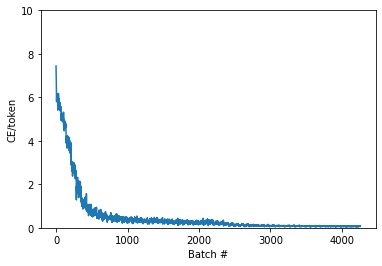

In [33]:
import matplotlib.pyplot as plt
plt.plot(batch_loss.logs)
plt.ylim([0, 10])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [34]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [35]:
model_name = 'portugues_trial_6'
tf.saved_model.save(translator, model_name,
                    signatures={'serving_default': translator.tf_translate})


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: portugues_trial_6/assets


INFO:tensorflow:Assets written to: portugues_trial_6/assets


In [36]:
model_name = 'portugues_trial_6'
reloaded = tf.saved_model.load(model_name)


In [37]:
# seems to be much more stable now - I suspect it's overfitting - 
# prompts are repeated 2-14 times so need to build a better mini test set

test_sentences = tf.constant(inputs[10:20])  # not used in training 
#test_sentences = tf.constant(inputs[20:30])  #targets[20:] is training

result = reloaded.tf_translate(test_sentences)

for orig, tr in zip(test_sentences, result['text']):
    print(orig.numpy().decode())
    print(tr.numpy().decode())
    print("------------")

print()

A notícia desta viagem causou grande espanto.
a a noticia de desta vi viagem com fazer grande grande espanto
------------
A Zélia jogou e meteu um belo golo na baliza.
a zelia a zelia jogou e meteu um belo golo na baliza
------------
A mãe do Flávio era florista.
a mae do flavio era salada
------------
Vendia lindos gladíolos e glicínias.
vendia lindos ge vendia lindos gladiolus e glicinias
------------
A Catarina e a Mira estão distraídas.
a catarina e a mira estao distraidas
------------
Quero eu, quero eu! Sou muito comilão, mas também dizem que sou bonacheirão.
quero eu quero eu sou muito comilao mas tambem dizem que sou la comilao mas tambem dizem que sou tudo la
------------
És muito simpático e pareces ser divertido.
esta este esta muito e simpatico e pareces ser divertido
------------
Mas com essa voz, acordavas-me a mim e aos meninos de noite!
mas com essa voz acurdavasme a mim e aos um meninos de noite
------------
Quase enraivecida, a cegonha largou a falar como uma matraca.